## The network SIR model

In order to introduce mean-field approach of network model, we choose SIR model since this is a simplest model in our implementation.
The dynamical equations are given as

\begin{align}
\dot{S_{in}}	    &=-\lambda_{in}(t)S_{in}+\sigma_{in},\\
\dot{I}_{in}^{a}	&=\alpha\lambda_{in}(t)S_{in}-\gamma_{I^{a}}I_{in}^{a},\\
\dot{I}_{in}^{s}	&=\bar{\alpha}\lambda_{in}(t)S_{in}-\gamma_{I^{s}}I_{in}^{s},\\
\dot{R}_{in}^{s}	&=\gamma_{I^{a}}I_{in}^{a} + \gamma_{I^{s}}I_{in}^{s}.\\
\end{align}

The key idea is to note that the rate of infection of a susceptible individual in age group `i` at the node `n` is given as

\begin{align}
\lambda_{in}(t)=\lambda^0_{in}(t)=\beta\sum_{j=1}^{M}\left(C_{ij}\frac{I_{jn}^{a}}{N^{H}_{jn}}+f_{sa}C_{ij}\frac{I_{jn}^{s}}{N^{H}_{jn}}\right),
\end{align}


Commute can then be modeled by changing this to


\begin{align}
\lambda_{in}^{T}(t)=\beta r^{T}\sum_{j=1}^{M}\sum_{m=1}^{N_{d}} \sum_{<k,l>} C_{ij} \frac{D_{j,kl}}{N^{H}_{j,l}} \frac{I_{jl}^{a} + f_{sa} I_{jl}^{s}}{N^{T}_{j,mn}} \frac{D_{i,mn}}{N^{H}_{i,n}},
\end{align}


while workplace interaction can be modeled as


\begin{align}
\lambda_{in}^{W}(t)=\beta r^{W}\sum_{j=1}^{M}\sum_{m,k=1}^{N_{d}} C_{ij} \frac{D_{j,mk}}{N^{H}_{jk}} \frac{I_{jk}^{a} + f_{sa} I_{jk}^{s}}{N^{W}_{jm}}  \frac{D_{i,mn}}{N^{H}_{in}}.
\end{align}

The derivation of all equations is wrriten in [the documentation](https://github.com/lukastk/PyRossGeo/tree/master/docs/mft-model.pdf).
The simulation then runs by choosing appropriate $\lambda$ as a function of time. The constants $r_T$ and $r_W$ control the strength of interactions. In this model, we assume that each route between the nodes connects neighbour nodes only.

The definition of the variables are in following.
$D_{i,nm}$ is the number of people working at node `n` and livingin `m` in the age group `i`, $N^{H}_{in}=\sum_{m} D_{i,mn}$ is the total number of residence in node `n` and $N^{W}_{in}=\sum_{m} D_{i,nm}$ is the total number of people working at node `n`.
$N_{i,nm}^{T}$ is the effective number of the commuter in the age group `i` using the route between `n` and `m`:

\begin{align}
N^{T}_{i,nm}=\sum_{<kl>}R_{i,kl}\frac{d_{kl}}{d_{nm}},
\end{align}

where $<kl>$ indicate summation of all pair of neighbour node $k$ and $l$ included in the shortest path between node 
`n` and `m` and $d_{nm}$ is the distance between node `n` and `m` along the shortest path. $R_{i,nm}=\sum_{<kl>}D_{i,kl}$ is the number of the commuter in the age group `i` using the route between the neighbor node `n` and `m`. The node `n` and `m` are included in the shortest path between node pair 
$(k,l)$ took up all combinations satisfying the conditions.
Hence, we only need $D_{i,nm}$ and $d_{nm}$ in order to construct this network model. $D_{i,nm}$ can be obtained census datasets and $d_{nm}$ can be determined by the geographical locations.


This tutorial provide how to determine $D_{i,nm}$ and $d_{nm}$ in the section 1 to 7, and how to perform the network SIR model in the section 8 and following.

To run the section 1 to 7, that is a part of other notebook coded by Jakub originally, the data and shape files need to be downloaded (~1GB) and put in the corresponding folders. They can be found here:

* 2011 Census: Table wu03ew (MSOA, method of transport), wu02ew (MSOA, age), wf01bew (OA) which can be downloaded [here](https://www.nomisweb.co.uk/census/2011/bulk/rOD1)
* Shape files: [MSOA](https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-boundaries-ew-bgc), [LAD](https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2019-boundaries-uk-bfc)
* Resident data: [for both 2011 and 2018](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/middlesuperoutputareamidyearpopulationestimates) in MSOA
* MSOA to LAD conversion: [here](https://geoportal.statistics.gov.uk/datasets/postcode-to-output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-february-2020-lookup-in-the-uk)
* Scottish Data workplace data: [here under the origin destination-travel heading](https://www.scotlandscensus.gov.uk/ods-web/data-warehouse.html#additionaltab)

**Practically, required data is already there and you can start from the section 8, if you prefer.**

**1**. Start to reading the census data. If there are census.txt and distances.txt, you can start at the section **8** which is the calculation section.

In [ ]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay, delaunay_plot_2d, Voronoi, voronoi_plot_2d
from scipy.sparse.csgraph import shortest_path, floyd_warshall, dijkstra, bellman_ford, johnson
from scipy.sparse import csr_matrix
import math
import pandas as pd
import geopandas as gpd

#First load everything you need
totalList= ["City of London", "Camden", "Greenwich", "Hackney", "Hammersmith and Fulham", "Islington", "Kensington and Chelsea", 
            "Lambeth", "Lewisham", "Southwark", "Tower Hamlets", "Wandsworth", "Westminster", "Barking and Dagenham", "Barnet", "Bexley", "Brent", 
            "Bromley", "Croydon", "Ealing", "Enfield", "Haringey", "Harrow", "Havering", "Hillingdon", "Hounslow", "Kingston upon Thames", 
            "Merton", "Newham", "Redbridge", "Richmond upon Thames", "Sutton", "Waltham Forest"]
df = pd.DataFrame(totalList) 
df=df.rename(columns={0:'lad19nm'})
geometry_msoa = gpd.read_file("shape/Middle_Layer_Super_Output_Areas_December_2011_Boundaries_EW_BGC.shp")
geometry_msoa = geometry_msoa.rename(columns={'msoa11cd':'msoa'})
geometry_lad = gpd.read_file("shape/Local_Authority_Districts_December_2019_Boundaries_UK_BFC.shp").rename(columns={'lad19cd':'lad'})
msoa_to_lad = pd.read_csv('data/PCD_OA_LSOA_MSOA_LAD_FEB20_UK_LU.csv', encoding="latin_1")

**2**. Here I make London but in principle this can be done for anything, files are all the standard files Pauls assumes in workplace data

In [ ]:
geometry_lad=geometry_lad.merge(df,on='lad19nm',how='right')
geometry_lad["ID"] = np.linspace(0,len(geometry_lad)-1,len(geometry_lad))
msoas_london = msoa_to_lad[msoa_to_lad.ladnm.isin(totalList).fillna(False)][['msoa11cd']].drop_duplicates().rename(columns={'msoa11cd':'msoa'})
geometry_msoa=geometry_msoa.merge(msoas_london, on='msoa')
geometry_msoa.plot()
geometry_msoa["ID"] = np.linspace(0,len(geometry_msoa)-1,len(geometry_msoa))
geometry_msoa.head()

**3**. Next you must make a list of neighbours using the "ID" column which can be changed

In [ ]:
geometry_msoa["NEIGHBORS"] = None  # add NEIGHBORS column
a=np.zeros(len(geometry_msoa))
AllNeighbors=np.array(a,dtype=object)
for index, ladSpec in geometry_msoa.iterrows():   
    # get 'not disjoint' countries
    neighbors = geometry_msoa[~geometry_msoa.geometry.disjoint(ladSpec.geometry)].ID.tolist()
    # remove own name from the list
    neighbors = [ name for name in neighbors if ladSpec.ID != name ]
    #Put it all together
    AllNeighbors[index]=neighbors

**4**. Next you add representative points to each msoa/lad/whatever

In [ ]:
geometry_msoa["Center"]=geometry_msoa.representative_point()
geometry_msoa.head()
## Here, Nnode value is obtained from msoa file
Nnode=len(geometry_msoa)

In [ ]:
AllNeighbors[0]

**5**. You extract these into a numpy format

In [ ]:
listarray = []
for pp in geometry_msoa["Center"]:
    listarray.append([pp.x, pp.y])
# list_arrays = [ np.array((geom["Center"][0][0], geom["Center"][1][0])) for geom in geometry_lad["Center"] ]
print(listarray[0])

**6**. Then you make an array of distance between nearest neighbours

In [ ]:
distances=np.zeros((len(geometry_msoa),len(geometry_msoa)))
Position = []
#Transforms it from a shapeobject into numpy
for pp in geometry_msoa["Center"]:
    Position.append([pp.x, pp.y])
#gets the distances
for i in range(0,len(AllNeighbors)):
    for j in range(0,len(AllNeighbors[i])):
        x=Position[i][0]-Position[int(AllNeighbors[i][j])][0]
        y=Position[i][1]-Position[int(AllNeighbors[i][j])][1]
        distances[i][int(AllNeighbors[i][j])]=math.sqrt(x*x+y*y)

Then you finish making a distance matrix between all the nodes and a matrix predecessors that tells you how to get from one node to the next

**7**. Next you load the commuting data

In [ ]:
age_commute_table = pd.read_csv("data/wu02ew_msoa.csv")
work_in_GLMSOA = age_commute_table[age_commute_table['Area of workplace'].isin(geometry_msoa.msoa) ]
work_in_GLMSOA =work_in_GLMSOA[work_in_GLMSOA['Area of residence'].isin(geometry_msoa.msoa)]
#work_in_GLMSOA =work_in_GLMSOA[work_in_GLMSOA['Area of residence']!=work_in_GLMSOA['Area of workplace']]
work_in_GLMSOA.index = pd.RangeIndex(len(work_in_GLMSOA.index))
work_in_GLMSOA.head()

Here, you load the commuting data of older than 16

In [ ]:
M = 7 #Aged Group
census_matrix = np.zeros((M + 1,Nnode,Nnode))
#census_matrix is constructed from census_file
#census_matrix[i][j] - i:place of work, j: usual residence
for i in range(0, len(work_in_GLMSOA)):
    indexhome=int(geometry_msoa.loc[geometry_msoa['msoa'] == work_in_GLMSOA["Area of residence"][i]]["ID"].values)
    indexwork=int(geometry_msoa.loc[geometry_msoa['msoa'] == work_in_GLMSOA["Area of workplace"][i]]["ID"].values)
    #Cij=int(work_in_GLMSOA["All categories: Age 16 and over"][i])
    census_matrix[1][indexwork][indexhome] = int(work_in_GLMSOA['16-24'][i])
    census_matrix[2][indexwork][indexhome] = int(work_in_GLMSOA['25-34'][i])
    census_matrix[3][indexwork][indexhome] = int(work_in_GLMSOA['35-49'][i])
    census_matrix[4][indexwork][indexhome] = int(work_in_GLMSOA['50-64'][i])
    census_matrix[5][indexwork][indexhome] = int(work_in_GLMSOA['65-74'][i])
    census_matrix[6][indexwork][indexhome] = int(work_in_GLMSOA['75+'][i])
    
f_distances = open('distances.txt', mode='w')
for i in range(Nnode):
    for j in range(Nnode - 1):
        f_distances.write(str(distances[i][j]) + ' ')
    f_distances.write(str(distances[i][Nnode - 1]) + '\n')
f_distances.close()

Next, you load the data of younger than 16 from population dataset

In [ ]:
msoas_pop = pd.read_csv("data/SAPE21DT3a-mid-2018-msoa-on-2019-LA-syoa-estimates-formatted.csv",sep=',')
msoas_pop = msoas_pop[msoas_pop['Contents'].isin(geometry_msoa.msoa) ]
msoas_pop=msoas_pop.drop(['Unnamed: 1'], axis=1)
msoas_pop.index = pd.RangeIndex(len(msoas_pop.index))
msoas_pop.head()

Here, census_matix store the population of younger then 16

In [ ]:
PopulationAgeStructuredDivided=np.zeros((msoas_pop.shape[0],8))
for j in range(0,msoas_pop.shape[0]):
    area_id = int(geometry_msoa.loc[geometry_msoa['msoa'] == msoas_pop['Contents'][j]]["ID"].values)
    PopulationAgeStructuredDivided[j][0] = area_id
    for i in range(0,5):
        PopulationAgeStructuredDivided[j][1] += float(msoas_pop.iloc[j,i+3].replace(',',''))
        census_matrix[0][area_id][area_id] += int(msoas_pop.iloc[j,i+3].replace(',',''))
    for i in range(5,16):
        PopulationAgeStructuredDivided[j][2] += float(msoas_pop.iloc[j,i+3].replace(',',''))
        census_matrix[0][area_id][area_id] += int(msoas_pop.iloc[j,i+3].replace(',',''))
    for i in range(16,25):
        PopulationAgeStructuredDivided[j][3] += float(msoas_pop.iloc[j,i+3].replace(',',''))
    for i in range(25,35):
        PopulationAgeStructuredDivided[j][4] += float(msoas_pop.iloc[j,i+3].replace(',',''))
    for i in range(35,50):
        PopulationAgeStructuredDivided[j][5] += float(msoas_pop.iloc[j,i+3].replace(',',''))
    for i in range(65,75):
        PopulationAgeStructuredDivided[j][6] += float(msoas_pop.iloc[j,i+3].replace(',',''))
    for i in range(75,91):
        PopulationAgeStructuredDivided[j][7] += float(msoas_pop.iloc[j,i+3].replace(',',''))
        
msoas_popAS=pd.DataFrame(PopulationAgeStructuredDivided)
msoas_popAS.head()

The commuting data write down into census.txt.

In [ ]:
msoas_popAS=msoas_popAS.rename(columns={0:"ID", 1:"0-5", 2:"5-15", 3:"16-24", 4:"25-34", 5:"35-49", 6:"50-64", 7:"65-74", 8:"75+"})
msoas_popAS.head()
msoas_popAS.to_csv('statPop.csv',index=False)

#Make Total
for i in range(Nnode):
    for j in range(Nnode):
        for alp in range(M):
            census_matrix[M,i,j] += census_matrix[alp,i,j]

f_census = open('census.txt', mode='w')
for k in range(M):
    for i in range(Nnode):
        for j in range(Nnode - 1):
            f_census.write(str(census_matrix[k][i][j]) + ' ')
        f_census.write(str(census_matrix[k][i][Nnode - 1]) + '\n')
f_census.close()

**8**. The following section is the calculation section. If there are census.txt and distances.txt, you can start at here.

In [ ]:
%%capture
# compile for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

**9**. $D_{i,nm}$ and $d_{nm}$ is constructed form census.txt and distances.txt. This dataset is the London including 983 nodes.

In [14]:
import numpy as np
import pyrossgeo
import matplotlib.pyplot as plt
import math
import os
import pandas as pd

model_def = {
    "settings" : {
        "classes" : ["S", "I"],
        "stochastic_threshold_from_below" : [1000, 1000],
        "stochastic_threshold_from_above" : [500, 500],
        "contact_scaling" : "powerlaw",
        "contact_scaling_parameters" : [0, 1.0, 0.5] # a + b * rho^c
    },

    "S" : {
        "linear"    : [],
        "infection" : [ ["I", "-beta"] ]
    },


    "I" : {
        "linear"    : [ ["I", "-gI"] ],
        "infection" : [ ["I", "beta"] ]
    }
}

M = 7 #Aged Group

cutoff = 0
Restricted = [] #the restirected area
if os.path.exists('census.txt') and os.path.exists('distances.txt'):
    f_census = open('census.txt')
    f_distances = open('distances.txt')
    c_lines = f_census.readlines()
    d_lines = f_distances.readlines()
    if len(c_lines) != len(d_lines)*M:
        print('Error. Wrong file Status\n')
        exit()
    
    Nd=int(len(c_lines)/M)
    census_matrix = np.zeros((M, Nd, Nd), dtype=np.uint16)
    distances=np.zeros((Nd, Nd))
    
    count = 0
    aged_id = 0
    for line in c_lines:
        parameters = line.split()
        for i in range(len(parameters)):
            census_matrix[aged_id,count,i] = float(parameters[i])
        count += 1
        if count == Nd:
            count = 0
            aged_id += 1

    #Restricted Area
    for alp in range(M):
        for i in Restricted:
            for j in range(Nd):
                cij = census_matrix[alp,i,j]
                census_matrix[alp,i,j] = 0.0
                census_matrix[alp,j,j] += cij
            
                cij = census_matrix[alp,j,i]
                census_matrix[alp,j,i] = 0.0
                census_matrix[alp,i,i] += cij
    
    #Cutoff
    nonzero_element = 0
    cutoff_total = 0
    c_matrix = census_matrix.copy()
    for alp in range(M):
        for i in range(Nd):
            for j in range(Nd):
                cij = c_matrix[alp,i,j]
                if cij > cutoff:
                    nonzero_element += 1
                    cutoff_total += c_matrix[alp,i,j]
                else:
                    census_matrix[alp,i,j] = 0.0
                    #max_wid = np.argsort(census_matrix[:,j])[Nd- 1]
                    census_matrix[alp,j,j] += cij
    print("Nonzero element " + str(nonzero_element) + '/' + str(M*Nd**2) + ' ' + str(cutoff_total))
                
    Nh = np.zeros((M + 1,Nd)) # The population of ususal residence
    Nw = np.zeros((M + 1,Nd)) # The number of people working in specific node.
    for alp in range(M):
        for i in range(Nd):
            Nh[alp,i] = 0.
            Nw[alp,i] = 0.
            for j in range(Nd):
                Nh[alp,i] += census_matrix[alp,j,i]
                Nw[alp,i] += census_matrix[alp,i,j]
    for alp in range(M):
        for i in range(Nd):
            Nh[M,i] += Nh[alp,i] ## N^{H}_{i} residence in Node i
            Nw[M,i] += Nw[alp,i] ## N^{W}_i ##working in Node i
    
    count = 0
    for line in d_lines:
        parameters = line.split()
        for i in range(len(parameters)):
            distances[count,i] = float(parameters[i])
        count += 1  

# set the matarix D_{nm}
Dnm = census_matrix.copy()

# set the matarix d_{nm}
dnm = distances.copy()

df = pd.read_csv('area.csv')
Area = df.values[:,1]/10**6

M1 = M*Nd

max_wid = np.argsort(Nw[M])[Nd- 1]
print("Maxmimum City at Working", max_wid, Nw[M,max_wid])
max_rid = np.argsort(Nh[M])[Nd- 1]
print("Maxmimum City of Residence", max_rid, Nh[M,max_rid])

Nonzero element 749693/6764023 4760944
Maxmimum City at Working 0 245633.0
Maxmimum City of Residence 859 9752.0


**10**. To start network model calculation, we must set the  contact matrix $C_{ij}$, model parameters and the initial state. $C_{ij}$ and model parameters can be inferred if we obtain the reasonable initial state. In this tutorial, we set the preliminary values.

In [15]:
# set the contact structure
C = np.identity(M)
for i in range(M - 1):
    C[i + 1, i] = 1.0
    C[i, i + 1] = 1.0
C *= 1.0
CH = C # in HOME
CT = C # in TRANS
CW = C # in WORK
        
# parameter
beta  = 0.2/24          # infection rate
gI    = 0.1/24          # recovery rate of infectives
rW    = 1.0             # the interaction control in WORK
rT    = 1.0             # the interaction control in TRANS
trv_restriction = 0.0   # travel restriction: 1.0 means everyone stay home


# Initial state
max_wid = np.argsort(Nw[M])[Nnode- 1]
#print("maxmimum population at Working", max_wid)
max_rid = np.argsort(Nh[M])[Nnode- 1]
#print("maxmimum population of Residence", max_rid)
min_wid = np.argsort(Nw[M])[0]
#print("minimum population at Working", min_wid)
min_rid = np.argsort(Nh[M])[0]
#print("minimum population of Residence", min_rid)

I_0 = np.zeros((Nnode*M))
I_0[1*Nnode + 859] += 10
R_0 = np.zeros((Nnode*M))
N_0 = np.zeros((Nnode*M))
for alp in range(M):
    for i in range(Nnode):
        N_0[Nnode*alp + i] = Nh[alp,i]
S_0  = N_0 - (I_0 + R_0)

# option
cutoff    = 1.0         # We ignore the D_{i,nm}, when D_{i,nm} is less than this number.
trv_restriction = 0.0   # travel restriction: 1.0 means everyone stay home

# the contact matrix
def contactMatrix(t):
    t_p_24 = t%24
    if t_p_24 < 8.0 or t_p_24 > 18.0: # in HOME
        return CH
    elif t_p_24 > 9.0 and t_p_24 < 17.0: # in WORK
        return CW
    else: # in TRANS
        return CT

# set the matarix D_{nm}
Dnm = census_matrix.copy()

# set the matarix d_{nm}
dnm = distances.copy()

# instantiate model
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
model = pyrossgeo.mft.RapidTransport(model_def, parameters, M, Nd, Dnm, dnm, Area, trv_restriction, cutoff)

{'S': 0, 'I': 1}
Infection relation 1
Infected
[1 1 0]
[0.         0.00833333 0.        ]
[1 1 0]
[[1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1.]]
#Start to calculate fixed variables
Nonzero element 371423/47348161 4565343.0
Max index J 1 983
Max index I 1 219
#Finish calculating fixed variables
powerlaw
[0.  1.  0.5]
1.0


 After setting the parameters, the calculation of network model will be started. **The modern laptop can finish this calculation about 1.5 minutes.** We can improve this computational rate.

In [17]:
rT=1.0
# intialize the model
parameters = {'beta':beta, 'gI':gI, 'rW':rW, 'rT':rT}
#model.initialize(parameters, trv_restriction)

# duration of simulation
Tf=24*100; Nf=Tf # Maximum time step equals as Tf/Nf
# simulate model
data=model.simulate(np.concatenate((S_0, I_0)), contactMatrix, Tf, Nf, Ti=0) # Rapid

travel restriction 0.0
cutoff 1.0
highspeed 0
#Calculation Start
Time 100.10010638136737
Time 200.10010638136737
Time 300.10010638136737
Time 400.10010638136737
Time 500.10010638136737
Time 600.1001063813674
Time 700.1001063813674
Time 800.1001063813674
Time 900.1001063813674
Time 1000.1001063813674
Time 1100.1001063813674
Time 1200.1001063813674
Time 1300.1001063813674
Time 1400.1001063813674
Time 1500.1001063813674
Time 1600.1001063813674
Time 1700.1001063813674
Time 1800.1001063813674
Time 1900.1001063813674
Time 2000.1001063813674
Time 2100.1001063813674
Time 2200.1001063813674
Time 2300.1001063813674
Time 2400.0


**11**. Loading the simulated data

In [18]:
S  = []
I = []
for i in range(Nnode*M):
    S.append(data.get('X')[i].flatten())
    I.append(data.get('X')[i + M1].flatten())
t = data['t']

# In 1 dimension, the data index in age group i and node j can be expressed as i*N_{d} + j.
#| Age group 0 | Age group 1 | Age group 2 | Age group 3 | Age group 4 | Age group 5 | Age group 6 |
#|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|1,2,...,N_{d}|

**12**. Plotting the results

/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


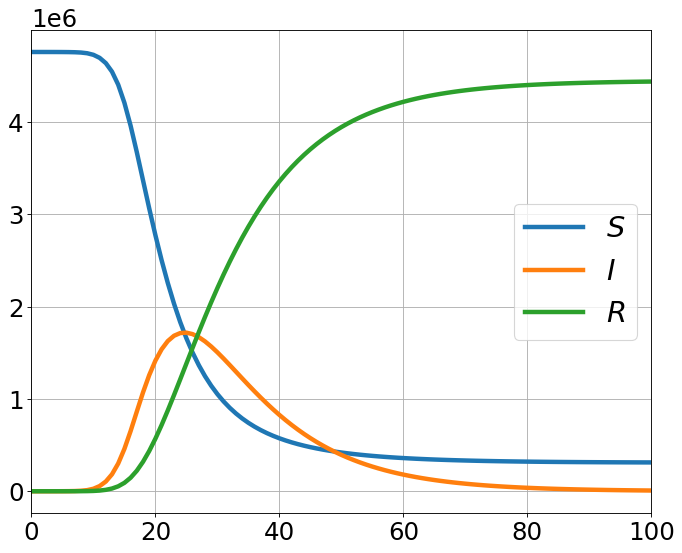

In [20]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

total_w = 0.0
total_r = 0.0
for i in range(Nnode):
    total_w += Nw[M][i]
    total_r += Nh[M][i]
#print('Toatl', total_w, total_r)

S_total = []
I_total = []
for i in range(len(I[0])):
    S_total.append(0.0)
    I_total.append(0.0)
for i in range(Nnode*M):
    S_total += S[i]
    I_total += I[i]
plt.plot(t/24, S_total, '-', label='$S$', lw=4)
plt.plot(t/24, I_total, '-', label='$I$', lw=4)
plt.plot(t/24, total_r - S_total - I_total, '-', label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
#plt.autoscale(enable=True, axis='x', tight=True)

ax=plt.subplot()
#ax.grid(which="both")
#ax.set_xlabel("x")
#ax.set_ylabel("y")

ax.set_xlim([0,100])
#ax.set_ylim([0,2.0*10**1])

f_data = open('network-SIR.txt', mode='w')
for i in range(len(t)):
    f_data.write(str(t[i]/24) + ' ' + str(S_total[i]) + ' ' + str(I_total[i]) + '\n')
f_data.close()

The results of each node

/home/hidekb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


(0.0, 100.0)

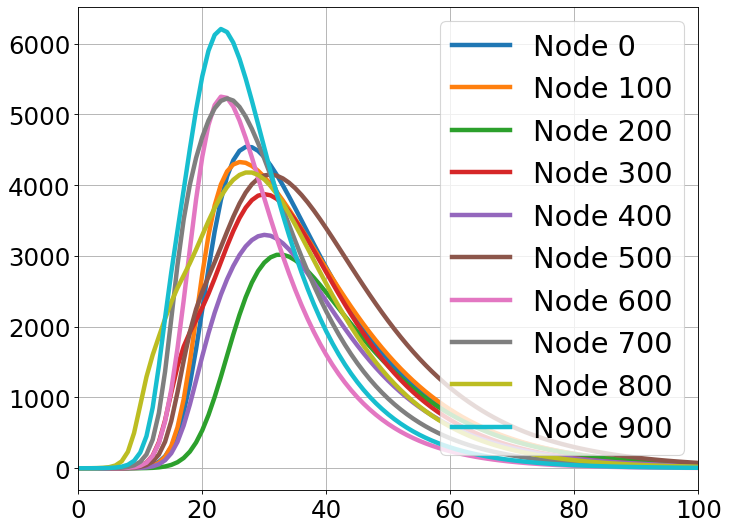

In [21]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

In_total = []
for i in range(Nnode):
    In_total.append(0.0)

for i in range(Nnode):
    for j in range(M):
        In_total[i] += I[j*M + i]
for i in range(0,Nnode,100):
    plt.plot(t/24, In_total[i], '-', label='Node ' + str(i), lw=4)

plt.legend(fontsize=26); plt.grid() 
#plt.autoscale(enable=True, axis='x', tight=True)

ax=plt.subplot()
#ax.grid(which="both")
#ax.set_xlabel("x")
#ax.set_ylabel("y")

ax.set_xlim([0,100])
#ax.set_ylim([0,2.0*10**1])